# Exhaustive Weather EDA/File Overview

### Table of Contents
* [Why Should You Trust Modified Store Info Files?](#Why-trust-modified-store-info)
* [Files: air/hpg_store_info_with_nearest_active_station](#Store-info-with-nearest-active-station)
* [Files: air/hpg_station_distances](#Station-distances)
    * [Helper: select_stations()](#Helper-select-stations)
* [File: feature_manifest](#Feature-manifest)
    * [Weather Feature Coverage - Visualization](#Weather-feature-coverage)
    * [Using feature_manifest with air/hpg_station_distances](#Feature-manifest-with-station-distances)
    * [Helpers to Analyze Coverage](#Helpers-to-analyze-coverage)
* [It's Gettin' Hot in Here (Station Coverage Heatmaps)](#Station-coverage-heatmaps)
* [Filling in Missing Data](#Fill-in-missing-data)
* [Combined Coverages by Prefecture](#Combined-coverages-by-prefecture)
* [Closest Station Proximity - Visualization](#Closest-station-proximity)
* [Distances Between Identical Stores](#Identical-stores-distances)
* [Files: weather_stations, nearby_active_stations](#Nearby-active-weather-stations)
    * [Mapping All Active Stations](#Mapping-all-active-stations)
* [Weather Station Background](#Weather-station-background)

# Introduction
I'll be adding to this kernel continually, as it is absolutely still a work in progress.
<br>
My aim in this kernel is to be as detailed as possible. If you'd like a quicker overview, take a look at [my other kernel.](https://www.kaggle.com/huntermcgushion/weather-station-location-eda)
<br>
If you have any suggestions or catch me screwing up anywhere, I'd truly love to hear about it! Thanks for your time!

In [12]:
% matplotlib inline

###############################################
# Import Miscellaneous Assets
###############################################
import numpy as np
import pandas as pd
import json
from datetime import datetime
from dateutil.parser import parse as date_parse
from collections import Counter
from pprint import pprint as pp
from tqdm import tqdm, tqdm_notebook
from IPython.display import display
import warnings
import os
import sys
from geopy.distance import vincenty, great_circle

###############################################
# Import Plotting Assets
###############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.pyplot import subplot, figure
import seaborn as sns
import folium
from folium import plugins as folium_plugins
from folium import features

###############################################
# Declare Global Variables
###############################################
plt.interactive(False)
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=FutureWarning)

weather_set_dir = 'jhz-weather-data'
weather_data_dir = '{}/1-1-16_5-31-17_Weather/1-1-16_5-31-17_Weather'.format(weather_set_dir)
original_data_dir = 'input'

weather_columns = [
    'avg_temperature', 'high_temperature', 'low_temperature', 'precipitation',
    'hours_sunlight', 'solar_radiation', 'deepest_snowfall', 'total_snowfall', 'avg_wind_speed',
    'avg_vapor_pressure', 'avg_local_pressure', 'avg_humidity', 'avg_sea_pressure', 
    'cloud_cover'
]

In [11]:
air_store_info = pd.read_csv('{}/air_store_info_with_nearest_active_station.csv'.format(weather_set_dir))
hpg_store_info = pd.read_csv('{}/hpg_store_info_with_nearest_active_station.csv'.format(weather_set_dir))

air_station_distances = pd.read_csv('{}/air_station_distances.csv'.format(weather_set_dir))
hpg_station_distances = pd.read_csv('{}/hpg_station_distances.csv'.format(weather_set_dir))

weather_stations = pd.read_csv('{}/weather_stations.csv'.format(weather_set_dir))
nearby_active_stations = pd.read_csv('{}/nearby_active_stations.csv'.format(weather_set_dir))
feature_manifest = pd.read_csv('{}/feature_manifest.csv'.format(weather_set_dir))

# Why Should You Trust Modified Store Info Files?
<a id="Why-trust-modified-store-info"></a>

Before now, you probably shouldn't. After all, I'm asking you to use my versions of the air_store_info and hpg_store_info files.
<br>
That sounds pretty scary, but let me show you why you can trust these files.

In [13]:
original_as_info = pd.read_csv('{}/air_store_info.csv'.format(original_data_dir))
original_hs_info = pd.read_csv('{}/hpg_store_info.csv'.format(original_data_dir))

display(original_as_info.head(5))
display(original_hs_info.head(5))

print('Air Equal: {}'.format(original_as_info.equals(air_store_info[original_as_info.columns])))
print('HPG Equal: {}'.format(original_hs_info.equals(hpg_store_info[original_hs_info.columns])))

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


Air Equal: True
HPG Equal: True


Now, we're sure that the original store_info files are equal to the appropriate columns in the modified files
<br>
The new files are just adding a few columns to the existing files.

# About air/hpg_store_info_with_nearest_active_station?
<a id="Store-info-with-nearest-active-station"></a>

We'll just look at hpg_store_info because all the same stuff gets added to air_store_info.

In [14]:
display(hpg_store_info.head())
print('These columns are added:')
pp([_ for _ in hpg_store_info.columns if _ not in original_hs_info.columns])

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,"""35.6436746642265""","""139.668220854814""",tokyo__setagaya-kana__setagaya,35.626667,139.62,4.757932,4.751874


These columns are added:
['latitude_str',
 'longitude_str',
 'station_id',
 'station_latitude',
 'station_longitude',
 'station_vincenty',
 'station_great_circle']


The 'latitude_str' and 'longitude_str' columns are just string versions of 'latitude' and 'longitude', but we need them to preserve the precision of those values so we can use the ' &lt;air/hpg&gt;station_distances' files.

# About air_station_distances and hpg_station_distances
<a id="Station-distances"></a>
Again, we'll just look at hpg_station_distances, as with hpg_store_info above.

In [15]:
print(hpg_station_distances.shape)
display(hpg_station_distances.head())

(1663, 132)


,station_id,station_latitude,station_longitude,"(35.6436746642265, 139.668220854814)","(34.8299255519268, 134.67307503026)","(35.6686002312873, 139.763042710922)","(33.576378885814, 130.339313030944)","(35.7049600607628, 139.828642317999)","(34.3921061951814, 132.461913549062)","(35.7504730896129, 139.668412382952)",...,"(34.3874999304076, 132.661308799626)","(34.8192452150664, 135.455217027399)","(35.2286300184325, 138.616270553172)","(37.838267244892, 139.104301421225)","(33.459353333184, 130.501845827137)","(34.5343100355169, 135.574890561587)","(37.5704782355036, 138.873286079977)","(33.6253345645257, 130.431896363042)","(43.4737679144369, 142.121081840925)","(37.9496613371687, 139.320881857858)"
0,aichi__ai-xi-kana__isaai,35.216667,136.698333,273.807155,189.740365,282.725621,612.251950,289.253536,398.263483,275.946323,...,380.665886,121.721628,174.611730,361.992653,602.451284,127.592239,326.005262,602.362086,1028.442446,383.450622
1,aichi__aki-kana__azo,35.078333,137.413333,214.313880,251.796992,223.331674,671.824800,230.175685,459.751286,217.965106,...,441.858496,181.155722,110.868817,341.702177,661.181614,178.717437,306.027812,662.058603,1016.291556,361.527761
2,aichi__centrair-kana__centrair,34.858333,136.805000,274.745122,195.009654,283.765888,612.414101,290.652680,401.582653,278.584673,...,383.540877,123.535588,170.286723,389.763469,601.466270,118.299929,353.750375,602.705152,1060.507816,410.570083
3,aichi__chapel-mountain-kana__chaw-yama,35.220000,137.660000,188.315295,275.990497,197.315052,697.208269,204.066820,484.364745,191.518327,...,466.582708,206.070761,87.062216,318.025164,686.816272,205.241088,282.616525,687.399839,993.369251,337.396234
4,aichi__gamagori-kana__gamagori,34.845000,137.216667,240.071397,232.657816,249.079769,649.076974,256.067699,438.899233,244.574215,...,420.815832,161.150492,134.613593,372.855680,637.885929,154.334072,337.111185,639.410354,1047.047395,392.808124


We can see that there are 1,663 rows, one for every weather file in the '1-1-16_5-31-17_Weather' directory.
<br>
For each row, we have the 'station_id', which is also the name of the corresponding weather file.
<br>
We have 'station_latitude' and 'station_longitude', and the remaining 129 columns are all of the unique coordinates in 'hpg_store_info'. 
<br>
This is what the 'latitude_str' and 'longitude_str' [columns in this section are for.](#Store-info-with-nearest-active-station)

Let's look at the first store in 'hpg_store_info' (hpg_6622b62385aec8bf), which is also represented by the above column in 'hpg_station_distances' immediately after 'station_longitude' ("(35.6436746642265, 139.668220854814)").

In [16]:
store = hpg_store_info.iloc[0]
lat_str, lon_str = store['latitude_str'], store['longitude_str']
lookup_coords = '({}, {})'.format(lat_str, lon_str).replace('"', '')
print(lookup_coords)

distances = hpg_station_distances[lookup_coords]
print(distances.values[:5])

(35.6436746642265, 139.668220854814)
[ 273.8071548   214.31388022  274.74512216  188.31529459  240.07139696]


As expected, these first five values mirror the first five values of hpg_station_distances['(35.6436746642265, 139.668220854814)'].
<br>
Let's keep going.

In [17]:
closest_station_distance = distances.min()
print('Distance to Closest Station: {} km'.format(closest_station_distance))

ids = hpg_station_distances['station_id'].values
closest_station_id = ids[distances.tolist().index(closest_station_distance)]
print('Closest Station ID: {}'.format(closest_station_id))

Distance to Closest Station: 4.757932176600001 km
Closest Station ID: tokyo__setagaya-kana__setagaya


These are the same values we see in the first row of 'hpg_store_info' for 'station_id' and 'station_vincenty' [in this section.](#Store-info-with-nearest-active-station)
<br>
But what if we wanted weather data from all stations in a 17 kilometer radius around this store?
<br>
Note: I'll go into why 17 km might be a useful distance further below.

### Helper: select_stations()
<a id="Helper-select-stations"></a>

In [18]:
stations_in_range = [(ids[_], distances[_]) for _ in range(len(distances)) if distances[_] <= 17]
stations_in_range = sorted(stations_in_range, key=lambda _: _[1], reverse=False)
pp(stations_in_range)

def select_stations(latitude_str, longitude_str, distance_df, effective_range=17.0, date_floor=None, top_n=None):
    """
    Filters stations based on proximity to coordinates, and termination status
    Note: if longitude_str is None, the first argument is assumed to be a properly formatted coordinate string
    :param latitude_str: latitude_str from air/hpg_store_info_with_nearest_active_station
    :param longitude_str: longitude_str from air/hpg_store_info_with_nearest_active_station
    :param distance_df: one of the following DFs: air_station_distances, hpg_station_distances
    :param effective_range: float in kilometers specifying the max distance a station can be from the store
    :param date_floor: if datetime, remove stations terminated before date_floor. If None, ignore termination
    :param top_n: if int, return at most top_n many stations. If None, all stations will be returned
    :returns: a list of tuples of (station_id, distance) that meet the given specifications - sorted by distance
    """
    if longitude_str is not None:
        _lookup_coords = '({}, {})'.format(latitude_str, longitude_str).replace('"', '')
    else:
        _lookup_coords = latitude_str
        
    _ids, _distances = distance_df['station_id'].values, distance_df[_lookup_coords]
    _result = [(_ids[_], _distances[_]) for _ in range(len(_ids)) if _distances[_] <= effective_range]
    
    if date_floor is not None and isinstance(date_floor, datetime):
        _result = [_ for _ in _result if '____' not in _[0] or date_parse(_[0].split('____')[1]) > date_floor]

    return sorted(_result, key=lambda _: _[1])[:top_n]

_test_0 = select_stations(lat_str, lon_str, hpg_station_distances)
_test_1 = select_stations(lat_str, lon_str, hpg_station_distances, date_floor=date_parse('2017-5-31'))
_test_2 = select_stations(lat_str, lon_str, hpg_station_distances, date_floor=date_parse('2017-5-31'), top_n=2)
_test_3 = select_stations(lat_str, lon_str, hpg_station_distances, date_floor=date_parse('1975-12-13'))

assert(_test_0 == stations_in_range)
assert(_test_1 == stations_in_range[:4] + [stations_in_range[-1]])
assert(_test_2 == stations_in_range[:2])
assert(_test_3 == stations_in_range)

[('tokyo__setagaya-kana__setagaya', 4.7579321766000007),
 ('tokyo__tokyo-kana__tonokyo', 9.1201964878599995),
 ('kanagawa__hiyoshi-kana__hiyoshi', 10.341102465300001),
 ('tokyo__nerima-kana__nerima', 12.582557308399998),
 ('tokyo__chofu-kana__NONE____1976-12-13', 12.8119330186),
 ('tokyo__haneda-kana__haneda', 14.250354447699999)]


Suddenly, we have 6 different stations that we can use data from for a single store.
<br>
Well actually its 5, because 'tokyo\_\_chofu-kana\_\_NONE\_\_\_\_1976-12-13' was terminated way back in 1976, which is before 2016.

Now that we know what's going on behind the scenes, we'll make the helper function ```select_stations``` for us to use later.
<br>
To quickly test ```select_stations``` and provide some examples, we'll set up a few simple assertion tests. 
<br>
We don't get any AssertionErrors, so it seems to be working.

Now, let's move on to how to use 'feature_manifest'.

# About feature_manifest
<a id="Feature-manifest"></a>

This file is very useful if you're concerned about a station having too many null values, or the fact that it only records precipitation.
<br>
And we should all be worried about that...

In [19]:
print('feature_manifest.shape: {}'.format(feature_manifest.shape))
active_feature_manifest = feature_manifest.loc[~feature_manifest['id'].str.contains('____')]
print('active_feature_manifest.shape: {}'.format(active_feature_manifest.shape))
display(active_feature_manifest.sample(10))

feature_manifest.shape: (1663, 15)
active_feature_manifest.shape: (1303, 15)


,id,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
1128,nagasaki__matsuura-kana__matsuura,0.998066,0.998066,0.998066,0.998066,0.996132,0.0,0.000000,0.000000,0.996132,0.000000,0.0,0.000000,0.0,0.0
792,kagawa__takamatsu-kana__takamatsu,1.000000,1.000000,1.000000,0.557060,1.000000,1.0,0.003868,0.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0
1182,niigata__matsushiro-kana__matsudai,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1585,yamagata__hamanaka-kana__hamanaka,0.994197,0.994197,0.994197,0.943907,0.000000,0.0,0.000000,0.000000,0.996132,0.000000,0.0,0.000000,0.0,0.0
309,gunma__nishinomaki-kana__nishinomaki,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.978723,0.000000,0.0,0.000000,0.0,0.0
1234,oita__saeki-kana__saiki,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0
192,fukushima__fukushima-kana__fukushima,1.000000,1.000000,1.000000,0.738878,1.000000,1.0,0.135397,0.090909,1.000000,0.990329,1.0,0.990329,1.0,1.0
1178,niigata__koide-kana__koide,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.932302,0.000000,0.0,0.000000,0.0,0.0
1661,yamanashi__uenohara-kana__wenohara,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
547,hokkaido_shiribeshi__akaigawa-kana__akayigawa,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


We got rid of 360 terminated stations in 'active_feature_manifest', and now we're looking at a sample of its rows.
<br>
The first column is 'id', which is the id of a weather station, and its the filename you're gonna look for if you want that station's data.
<br>
The remaining columns are each of the different weather features, and they all have values between 0.0 and 1.0 (inclusive).

In the interest of full disclosure and to make its contents abundantly clear, here is the exact code I used to make the feature manifest for each weather file...

<pre><code class="python">num_rows = float(df.shape[0])
null_counts = df.isnull().sum()
coverage_manifest = [((num_rows - float(null_counts[_])) / num_rows) for _ in weather_columns]
</code></pre>

Note: In the above code block, ```df``` is a DataFrame read directly from a weather file, and ```weather_columns``` is a list of the names of the 14 weather features.

Now, we want to figure out how many stations are supposed to record each feature, and then how often they actually do.
<br>
So here's a clustermap showing just that! A heatmap will work, as well, but the clustermap looks better for now.

# Weather Feature Coverage
<a id="Weather-feature-coverage"></a>


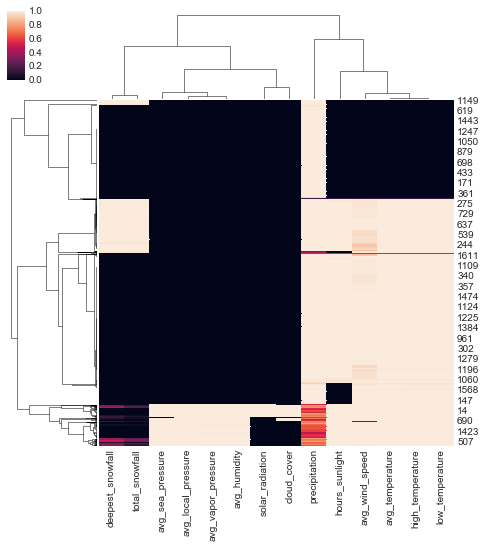

In [20]:
ax = sns.clustermap(active_feature_manifest.drop(['id'], axis=1), figsize=(8, 8))
plt.show()

At first glance, this might not look very promising, but keep reading and it'll get better.

Starting on the left, we see that very few stations have data on snowfall; although, that is to be expected.
<br>
The Japan Meteorological Agency states that snow depth is recorded only in areas of heavy snowfall, which is only ~280 stations.

Next, we come to the various pressure measurements, and humidity, which are only recorded at a few hundred stations. 

Even fewer stations record solar radiation and cloud cover.

The light at the end of the tunnel: precipitation, which is recorded at all but 3 of the active stations.
<br>
In fact, at 910 stations, we have precipitation data for every single day.

The remaining features (sunlight, wind, and temperature) all have relatively high coverages, as well.

### Interpreting the Colors Above
It may be worth mentioning that a coverage of 0 *probably almost always* means that station was never meant to record the feature.
<br>
What this means for the above clustermap is that the pale/white (or whatever) sections are at or near full coverage.
<br>
Sections with a red/purple/orange color are meant to record that feature, but either failed to part of the time, or the results seemed questionable to the JMA.
<br>
Black sections indicate that 1) the station was never intended to record this feature, so it didn't, or 2) the station failed to record the feature, or produced questionable results for every single day in this 517-day span.

Note: I'm pretty sure 0 coverage is always due to the former of the above two cases, but I mention the latter because I suppose it's possible, no matter how unlikely it may seem.

# Using feature_manifest with air/hpg_station_distances
<a id="Feature-manifest-with-station-distances"></a>

The clustermap above is great, but it might be missing the point. After all, we don't really care about all of the weather stations.

We only care about the weather stations that are close to our stores. So let's look at those.

In [21]:
all_ranges, d_floor = ['10', '17', '20'], date_parse('2017-5-31')
separate_results, combined_results = {_: [] for _ in all_ranges}, {_: [] for _ in all_ranges}

for sys_distances in [air_station_distances, hpg_station_distances]:
    for coords in tqdm(sys_distances.columns.values[3:], leave=False):
        for e_range in all_ranges:
            res = select_stations(coords, None, sys_distances, effective_range=int(e_range), date_floor=d_floor)
            
            separate_results[e_range].extend([_[0] for _ in res if _[0] not in separate_results[e_range]])
            combined_results[e_range].append([_[0] for _ in res])

print('#' * 30 + ' separate_results ' + '#' * 30)
for _r in all_ranges:
    print('{}     {}'.format(_r, len(separate_results[str(_r)])))
print('#' * 30 + ' combined_results ' + '#' * 30)
for _r in all_ranges:
    print('{}     {}'.format(_r, len(combined_results[str(_r)])))

############################## separate_results ##############################
10     65
17     126
20     151
############################## combined_results ##############################
10     237
17     237
20     237


### What Just Happened?

In line 1, we declare ```all_ranges``` as the ranges we're interested in, and ```d_floor``` as the final date in the competition.

In line 2, we declare two variables: ```separate_results, combined_results```. Notice that their initial values are exactly the same: a dict, whose keys are the elements of ```all_ranges```, pointing to empty lists. We'll see soon why we have both of them.

In line 4, we look at ```air_station_distances``` and ```hpg_station_distances``` [from this section](#Station-distances) via ```sys_distances```. 
<br>
In line 5, ```coords``` loops through columns in ```sys_distances``` that are coordinate strings, which is all columns starting at index 3.
<br>
In line 6, we loop through ```all_ranges``` from line 1, via ```e_range```.

Here's the good stuff.
<br>
In line 7, we call ```select_stations```, [the helper function we made earlier](#Helper-select-stations), and we pass it:
- ```coords``` from line 5,
- ```None``` (see the ```select_stations``` docstring if you don't understand this),
- ```sys_distances``` DataFrame from line 4, and
- the keyword arguments ```effective_range=int(e_range), date_floor=d_floor```

And we receive a list of (station_id, distance) tuple pairs, as ```res```

In line 9, we **extend** ```separate_results[e_range]``` by all the new station_ids in ```res```.
<br>
In line 10, we **append** all of the station_ids to ```combined_results[e_range]```.
<br>
That means ```separate_results[e_range]``` is a list of unique station_ids; whereas, ```combined_results[e_range]``` is a list of lists, whose contents are all the station_ids from each ```res```.

Finally, we print out the lengths of the lists at each range in ```separate_results``` and ```combined_results```.

Notice that the lengths in ```separate_results``` increase because they correspond to the number of unique weather stations that are within the given range of any store. So when we're looking everywhere within a 10 km radius around our stores, we find 65 different stations. But when the radius is increased to 20 km, we find 151 stations.

On the other hand, the lengths in ```combined_results``` are 237 at all ranges because in line 10, we appended the list of station_ids to each range in ```combined_results```, meaning the lengths correspond to the number of coordinate group strings in ```air_station_distances``` and ```hpg_station_distances``` combined (108 and 129, respectively), which adds up to 237.

Remember that the length 237 is the number of lists of station_ids in these elements; the lists inside actually contain far fewer ids.

### Helpers to Analyze Coverage
<a id="Helpers-to-analyze-coverage"></a>

Let's set up a few helper functions to simplify our visualization of weather station coverages.

In [22]:
def build_coordinate_count_map(store_info, station_distances):
    info_by_coordinates = {_: 0 for _ in station_distances.columns.values[3:]}

    for i, row in store_info.iterrows():
        coordinate_str = '({}, {})'.format(row['latitude_str'], row['longitude_str']).replace('"', '')
        info_by_coordinates[coordinate_str] += 1

    return pd.DataFrame(
        columns=['coordinates', 'coordinate_count'],
        data=[[_k, info_by_coordinates[_k]] for _k in station_distances.columns.values[3:]]
    )

def filter_coverage(manifest, target_vals, do_isin=False, target_col='id', reindex=True, drop_cols=['id']):
    if do_isin is False:
        _res = pd.DataFrame(
            columns=manifest.columns.values,
            data=[manifest.loc[manifest[target_col] == _, :].values[0] for _ in target_vals]
        )
    else:
        _res = manifest.loc[manifest[target_col].isin(target_vals)]
    
    _res = _res.reset_index(drop=True) if reindex is True else _res
    _res = _res.drop(drop_cols, axis=1) if drop_cols is not None else _res
        
    return _res

air_coord_counts = build_coordinate_count_map(air_store_info, air_station_distances)
hpg_coord_counts = build_coordinate_count_map(hpg_store_info, hpg_station_distances)
coordinate_map = pd.concat((air_coord_counts, hpg_coord_counts)).reset_index(drop=True)
all_coords = air_station_distances.columns.values[3:].tolist() + hpg_station_distances.columns.values[3:].tolist()

# station_ids must be a list of length == len(all_coords)
# station_ids must contain a station_id for each coordinate group in all_coords
# station_ids must also be in the same order as all_coords
# i.e. station_ids[i] is the station for the stores at all_coords[i]
def coverage_by_store(station_ids, drop_cols=['id']):
    all_nearby_station_ids = []
    for i, coords in enumerate(all_coords):
        coord_count = coordinate_map.loc[coordinate_map['coordinates'] == coords, 'coordinate_count'].values[0]
        all_nearby_station_ids.extend([station_ids[i]] * coord_count)
    
    return filter_coverage(feature_manifest, all_nearby_station_ids, drop_cols=drop_cols)

# It's Gettin' Hot in Here (Station Coverage Heatmaps)
<a id="Station-coverage-heatmaps"></a>

Our first clustermap of station coverages [(here)](#Weather-feature-coverage) was only the tip of the proverbial iceberg.

First, we'll look at three heatmaps side-by-side.
<br>
\#1 (leftmost) will look familiar because it is the heatmap version of the clustermap we saw earlier, shown for comparison.
<br>
\#2 will show coverages for every **coordinate group's** nearest station. Despite some overlap, it only shows the essential stations.
<br>
\#3 will show coverages for every **store's** nearest station. We'll go over the differences between the plot \#2 and this one later.

Here we go...

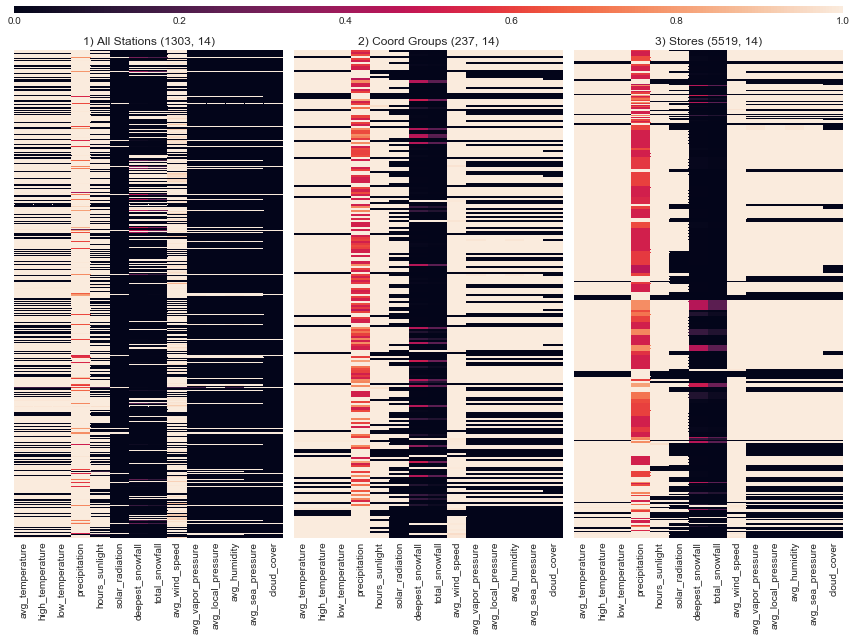

In [23]:
###############################################
# Prepare the Data
###############################################
# Coverage for the nearest station for every store coordinate group
nearest_by_coord_group = filter_coverage(feature_manifest, [_[0] for _ in combined_results['20'] if len(_) > 0])
# Coverage for the nearest station for every store (same values as above, but applied to every store)
nearest_by_store = coverage_by_store([_[0] for _ in combined_results['20']], drop_cols=None)

###############################################
# Plot the Data
###############################################
fig = figure(figsize=(12, 9))
gs = gridspec.GridSpec(13, 3)

cbar_ax = subplot(gs[0, :])
ax1, ax2, ax3 = subplot(gs[1:, 0]), subplot(gs[1:, 1]), subplot(gs[1:, 2])

cbar_kwargs = dict(cbar=True, cbar_ax=cbar_ax, cbar_kws=dict(orientation='horizontal'))
sns.heatmap(active_feature_manifest.drop(['id'], axis=1), ax=ax1, yticklabels=False, cbar=False)
sns.heatmap(nearest_by_coord_group, ax=ax2, yticklabels=False, cbar=False)
sns.heatmap(nearest_by_store.drop(['id'], axis=1), ax=ax3, yticklabels=False, **cbar_kwargs)

ax1.set_title('1) All Stations {}'.format(active_feature_manifest.drop(['id'], axis=1).shape))
ax2.set_title('2) Coord Groups {}'.format(nearest_by_coord_group.shape))
ax3.set_title('3) Stores {}'.format(nearest_by_store.drop(['id'], axis=1).shape))

plt.tight_layout()
plt.show()

### What are We Looking At?

**Left**
<br>
As mentioned earlier, this plot shows the same data as [this one](#Weather-feature-coverage). It's just shown as a heatmap here, but its as unappealing as ever.
<br>
It shows the coverage for every weather station that is active during our target timeframe.
<br>
We don't want to work with that... And we don't have to.

**Center**
<br>
Alright this one doesn't look as bad as the last one. It's not fantastic, but at least it doesn't make me want to throw my computer.
<br>
Plot \#2 shows the station closest to each unique store coordinate pair, hence 237 rows (108 unique air coordinates, plus 129 for hpg).
<br>
But wait, there's more.

**Right**
<br>
Things are looking up. This shows the closest station to every store, of which there are 5,519 (829 from air, plus 4,690 from hpg).
<br>
Basically, we're looking at the same rows from heatmap \#2, multiplied by how many stores are located at each set of coordinates.
<br>
Yes, there's a lot of duplication, but the bottom line is that this is the data we're working with if we want every store's nearest station.

But we're not done yet. Hold on to your overfitting models!

# Filling in Missing Data
<a id="Fill-in-missing-data"></a>

Even though we were able to show that the missing data problem wasn't as big as we thought, it's still the obvious problem.

One way to mitigate this issue is to combine the data from different stations that are near each other.
<br>
Let's see how our coverage is affected by combining multiple stations' data. We'll use ```combined_results``` [from this earlier section](#Feature-manifest-with-station-distances).

 Let's start with some helper functions. We'll also read in all of the weather station data we'll need at this point.

In [ ]:
weather_data = {_: pd.read_csv('{}/{}.csv'.format(weather_data_dir, _)) for _ in separate_results['20']}

def calculate_coverage(df):
    num_rows = float(df.shape[0])
    null_counts = df.isnull().sum()
    return [((num_rows - float(null_counts[_])) / num_rows) for _ in weather_columns]

def build_daily_combined_coverage(stations):
    summed_df = None
    if len(stations) == 0:
        return np.zeros(14).tolist()

    for station in stations:
        station_df = weather_data[station].drop(['calendar_date'], axis=1)
        summed_df = station_df if summed_df is None else summed_df.add(station_df, fill_value=0)

    return calculate_coverage(summed_df)

combined_coverages = {_: [] for _ in all_ranges}

for i, row in coordinate_map.iterrows():
    for e_range in all_ranges:
        _current_coverage = build_daily_combined_coverage(combined_results[e_range][i])
        combined_coverages[e_range].extend([[row['coordinates']] + _current_coverage] * row['coordinate_count'])

combined_coverage_dfs = {_k: pd.DataFrame(
    columns=['coordinates'] + weather_columns, data=_v
) for _k, _v in combined_coverages.items()}

In [ ]:
fig = figure(figsize=(12, 15))
gs = gridspec.GridSpec(19, 2)

cbar_ax = subplot(gs[0, :])
ax1, ax2 = subplot(gs[1:10, 0]), subplot(gs[1:10, 1])
ax3, ax4 = subplot(gs[10:, 0]), subplot(gs[10:, 1])

cbar_kwargs = dict(cbar=True, cbar_ax=cbar_ax, cbar_kws=dict(orientation='horizontal'))
sns.heatmap(nearest_by_store.drop(['id'], axis=1), ax=ax1, yticklabels=False, xticklabels=False, cbar=False)
sns.heatmap(combined_coverage_dfs['10'].drop(['coordinates'], axis=1), ax=ax2, yticklabels=False, xticklabels=False, cbar=False)
sns.heatmap(combined_coverage_dfs['17'].drop(['coordinates'], axis=1), ax=ax3, yticklabels=False, cbar=False)
sns.heatmap(combined_coverage_dfs['20'].drop(['coordinates'], axis=1), ax=ax4, yticklabels=False, **cbar_kwargs)

ax1.set_title('1) Where We Left Off - No Combinations {}'.format(nearest_by_store.drop(['id'], axis=1).shape))
ax2.set_title('2) Combined - 10 km {}'.format(combined_coverage_dfs['10'].drop(['coordinates'], axis=1).shape))
ax3.set_title('3) Combined - 17 km {}'.format(combined_coverage_dfs['17'].drop(['coordinates'], axis=1).shape))
ax4.set_title('4) Combined - 20 km {}'.format(combined_coverage_dfs['20'].drop(['coordinates'], axis=1).shape))

plt.tight_layout()
plt.show()

### What's Going On?

The above heatmaps are numbered in the order we'll be looking at them.

**1)** The upper-left heatmap is (as its title suggests) the last heatmap from [this section](#Station-coverage-heatmaps), as a benchmark for the next three heatmaps.

**2)** This heatmap shows the combined coverage for all stores, when stores can rely on all weather stations in a 10 km radius.
<br>
Some of the null values are already filling in, but also notice the black stripes in ```precipitation```, where there were none before.
<br>
This is because plot \#1 takes the nearest station for every store regardless of its distance; whereas, plot \#2 looks strictly within 10 km.
<br>
You could easily make a hybrid of these two to ensure every store has at least one station, but that's what's going on there.

**3)** In the lower-left heatmap, we start to see significant improvements after increasing the range to 17 km (as you probably expected).
<br>
Just like plot \#2, by looking at ```precipitation```, we can see that there are still a few stores without any weather station in range.
<br>
These are actually 14 hpg stores that are 17.18 km away from any station. So close! We'll look at them later on.

**4)** When we increase the range to 20 km, of course we see that all stores now have at least one station within range.
<br>
Additionally, it looks like we get nearly full coverage in the following features: ```avg_temperature, high_temperature, low_temperature, precipitation, hours_sunlight, avg_wind_speed```. We also have respectable (in my opinion) coverages in most non-snow-related features.

Judge for yourself whether the improvement from plot \#1 to plot \#4 is noteworthy. I think it's significant progress.
<br>
And we're not stopping there.

# Combined Coverages by Prefecture
<a id="Combined-coverages-by-prefecture"></a>

If you're thinking there's something weird about the distribution of our null spots, you're not alone. Let's get to the bottom of that.

We'll add a ```coordinates``` column to our store_info DataFrames to simplify things.
<br>
Then, we'll make a copy of plot \#4's DataFrame for us to use, and we'll add the ```prefecture``` and ```area``` for each store. 

In [ ]:
def coord_format(row):
    return '({}, {})'.format(row['latitude_str'], row['longitude_str']).replace('"', '')

air_store_info['coordinates'] = air_store_info.apply(coord_format, axis=1)
hpg_store_info['coordinates'] = hpg_store_info.apply(coord_format, axis=1)

def clean_string(a_string):
    if sys.version_info < (3, 0):
        a_string = a_string.decode('utf-8').encode('unicode-escape')
    return a_string.replace('\u014d', 'o').replace('\u014c', 'O')

def find_location(row, prefecture=True):
    for (col, store_info) in [('air_area_name', air_store_info), ('hpg_area_name', hpg_store_info)]:
        if row['coordinates'] in store_info['coordinates'].values:
            area = clean_string(store_info.loc[store_info['coordinates'] == row['coordinates']][col].values[0])
            return area.split(' ')[0].split('-')[0] if prefecture is True else area
            
combined_df_20 = combined_coverage_dfs['20'].copy()
combined_df_20['prefecture'] = combined_df_20.apply(find_location, axis=1)
combined_df_20['area'] = combined_df_20.apply(lambda _: find_location(_, prefecture=False), axis=1)

display(combined_df_20.head())

To recap, what we now have in ```combined_df_20``` is a DataFrame with rows corresponding to each store, showing the combined coverage for all stations within 20 km of that store, along with that store's ```coordinates```, ```prefecture```, and ```area```.

What we want to see is how the coverage heatmap looks when we sort our stores by location.
<br>
If you're wondering why we should care, I don't blame you.

Here's what's going on: 
<br>
Besides the coverage heatmap above just looking a bit odd, we also know that the JMA selectively records features in certain areas.
<br>
Admittedly, we only know this for certain with regards to the snow-related features.
<br>
Specifically, snow data is only recorded in areas known to experience heavy snowfall.

So, there's a good chance we'll see some patterns emerge in the coverage of our snow features at least.

### Sorting by Area

In the cell below, we're copying our last DataFrame, and sorting its rows by ```prefecture``` and ```area```. Then we reset its indices.

That should be enough to try to find the patterns we're looking for, but we can do better.
<br>
```find_changes``` takes in a sorted DataFrame, a column name, and an optional ```handler``` that is called on ```target_col``` values.
<br>
Finally, we call ```find_changes``` on ```sorted_df_20``` three times, each time with different ```target_col``` and ```handler``` values.

What we end up with are lists of the indexes at which the value of ```target_col``` changes, along with the corresponding values.

We'll see very soon why these will be useful.

In [ ]:
sorted_df_20 = combined_df_20.copy()
sorted_df_20.sort_values(by=['prefecture', 'area'], axis=0, inplace=True)
sorted_df_20.reset_index(drop=False, inplace=True)

def find_changes(df, target_col, handler=None):
    indexes, values, previous_value = [], [], None
    for i, row in df.iterrows():
        current_value = row[target_col] if handler is None else handler(row[target_col])
        if previous_value != current_value:
            previous_value = current_value
            indexes.append(i)
            values.append(current_value)
                
    return indexes, values

(prefecture_indexes, prefecture_values) = find_changes(sorted_df_20, 'prefecture')
(city_indexes, city_values) = find_changes(sorted_df_20, 'area', handler=lambda _: ' '.join(_.split(' ')[:2]))
(area_indexes, area_values) = find_changes(sorted_df_20, 'area')

print('Number of prefecture changes: {}'.format(len(prefecture_indexes)))
print('Number of city changes:       {}'.format(len(city_indexes)))
print('Number of area changes:       {}'.format(len(area_indexes)))

In [ ]:
previous_df = combined_coverage_dfs['20'].drop(['coordinates'], axis=1)
display_df = sorted_df_20.drop(['index', 'coordinates', 'prefecture', 'area'], axis=1)

fig = figure(figsize=(12, 15))
gs = gridspec.GridSpec(19, 2)

cbar_ax = subplot(gs[0, :])
ax1, ax2 = subplot(gs[1:10, 0]), subplot(gs[1:10, 1])
ax3, ax4 = subplot(gs[10:, 0]), subplot(gs[10:, 1])

cbar_kwargs = dict(cbar=True, cbar_ax=cbar_ax, cbar_kws=dict(orientation='horizontal'))
sns.heatmap(previous_df, ax=ax1, xticklabels=False, yticklabels=False, cbar=False)
sns.heatmap(display_df, ax=ax2, xticklabels=False, yticklabels=False, cbar=False)
sns.heatmap(display_df, ax=ax3, yticklabels=False, cbar=False)
sns.heatmap(display_df, ax=ax4, yticklabels=False, **cbar_kwargs)

_ = ax1.set_title('1) Where We Left Off {}'.format(previous_df.shape))
_ = ax2.set_title('2) Sorted - No Lines {}'.format(display_df.shape))
_ = ax3.set_title('3) Sorted - City Lines {}'.format(display_df.shape))
_ = ax4.set_title('4) Sorted - Prefecture Lines {}'.format(display_df.shape))

ax3.hlines(city_indexes, *ax3.get_xlim(), colors='#00e600')
ax4.hlines(prefecture_indexes, *ax4.get_xlim(), colors='#00e600')

for i, index_update in enumerate(prefecture_indexes):
    ax4.text(
        x=ax4.get_xlim()[1] + 0.5,
        y=index_update - 15 if i % 2 == 1 else index_update + 15,
        s='{} - {}'.format(index_update, prefecture_values[i]),
        ha='left',
        va='top' if i % 2 == 1 else 'bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

### Why Aren't The Plots as Colorful as Before?

**1)** As you've probably come to expect, our upper-left plot is our final plot from [this earlier section](#Fill-in-missing-data) as a helpful comparison.
<br>
Remember, this DataFrame's rows represent all our stores and their combined coverages within 20 km (like the next three plots).
<br>
The only thing that's different about the data in plot \#1 is that it hasnt been sorted by location.

**2)** This plot shows the same exact content as plot \#1, but after its rows have been sorted alphabetically by ```area```.
<br>
We can see that the sections with non-null snow features have been reorganized from lots of small strips into two larger groups.
<br>
But we don't really know what those two groups are, and that's why we collected the indexes at which our locations changed earlier.

**3)** The lower-left plot's heatmap is identical to plot \#2, but it is overlaid by bright green lines showing where the row's city changes.
<br>
This one is cool, but its too crowded to see anything really useful.

**4)** In the last plot, we are again looking at a heatmap identical to plot \#2, but with a line overlay whenever the prefecture changes.
<br>
This is just enough to see that at index 784, we start looking at the Hokkaido prefecture and we suddenly have snowfall data.
<br>
When we change prefectures, the snow features become null again, until we reach the Niigata prefecture at index 1,733.

What this shows us is that basically outiside of Hokkaido and Niigata, we don't even need to think about snow.
<br>
It's now much easier for our models to leverage snow data, and it seems like snow would have a significant effect on how many visitors a restaurant has.


# Let it Snow!

Just like that, we see that ```deepest_snowfall``` and ```total_snowfall``` are only recorded in the Hokkaido and Niigata prefectures!
<br>
Not only that, but it also looks like those two prefectures have nearly full coverage across the board!

On the question of what to do with this information, my first thought is using separate ensembles to handle the weather data:
- One when looking at weather in these two prefectures 
- And at least one more to handle other prefectures

I'm sure you all have other ideas, and I would love to hear them in the comments if you'd like to share!

# Correlations Between Combined Stations
## COMING SOON


# Closest Station Proximity
<a id="Closest-station-proximity"></a>

In other words, how close are our closest stations?
<br>
We know that our air stores comprise 108 distinct coordinate groups, and our hpg stores are in 129 different coordinate groups.
<br>
It's important to understand how much distance is between each of these groups and their nearest stations in order to assess the reliability of the weather data.

Perhaps it's asking too much to hope for all of the groups to be very close to a station, so ideally, those groups that contain the greatest number of stores will be closer to a station.
<br>
It's less important (although important nonetheless) that some group containing only a single store is very close to a station.

In [ ]:
air_info_copy, hpg_info_copy = air_store_info.copy(), hpg_store_info.copy()

air_info_copy['coordinate_count'] = air_info_copy.groupby(
    ['latitude', 'longitude']
).latitude.transform('count').astype(int)

hpg_info_copy['coordinate_count'] = hpg_info_copy.groupby(
    ['latitude', 'longitude']
).latitude.transform('count').astype(int)

In [ ]:
sns.distplot(air_info_copy['station_vincenty'], rug=True, kde=True)
plt.title('AIR - Distances (km) to Stations Distribution')
plt.show()

sns.distplot(hpg_info_copy['station_vincenty'], rug=True, kde=True)
plt.title('HPG - Distances (km) to Stations Distribution')
plt.show()

The above distribution plots show us that most of our stores are within 10 kilometers of a station; although, there are a few outliers.
<br>
If the plots above aren't quite clear enough, the joint plots below might help.

In [ ]:
p = sns.jointplot(x='station_vincenty', y='coordinate_count', data=air_info_copy, kind='kde')
plt.title('AIR KDE Joint Plot', loc='left')
p.plot_joint(plt.scatter, c='r', s=30, linewidth=1, marker='x')
plt.show()

p = sns.jointplot(x='station_vincenty', y='coordinate_count', data=hpg_info_copy, kind='kde')
plt.title('HPG KDE Joint Plot', loc='left')
p.plot_joint(plt.scatter, c='r', s=30, linewidth=1, marker='x')
plt.show()

The joint plots show most of the closest weather stations are within about 8 km of the store we are looking at.

The air outliers are 3 groups whose nearest stations are between 10 and 12 km away.
<br>
The coordinate_count values seem low, so there are probably under 20 air stores that are more than 10 km away from a station.

The hpg outliers are more numerous and confusing, largely because there are 4,690 HPG stores, compared to air's 829.
<br>
They seem to be: a little over 100 stores (4 unique coordinates) that are between 12 and 15 km from their nearest station, along with about 10 more that are a whopping 17.5 km away.

But let's not just trust the plots. Let's check the data...

In [ ]:
def view_distances(df, distance, cols=['station_vincenty', 'coordinate_count']):
    return df[cols].groupby(cols).filter(
         lambda _: _[cols[0]].mean() > distance
    ).drop_duplicates().sort_values(by=cols).reset_index(drop=True)

display(view_distances(air_info_copy, 8))

For the air stores, there are 18 stores (4 unique coordinates) that are between 8 and 9 km away from their closest station.
<br>
There are also 15 stores (4 unique coordinates) that are more than 10 km away from a station, with the furthest being 12.21 km away. 

Now for the hpg stores...

In [ ]:
display(view_distances(hpg_info_copy, 10))

For the hpg stores, we see 147 stores (8 unique coordinates) between 10 and 14 km away from a station.
<br>
Then, there are 16 stores (2 unique coordinate pairs) located more than 14 km from a station, with the furthest being 17.18 km away.

The good news is that all of our store are within about 17 km of a weather station.
<br>
Additionally, those coordinate groups that are further from a weather station tend to have fewer stores in them.

The bad news is that I have very little to base my 17 km range on. I have no idea what the effective range of each weather station is.
<br>
I'm just assuming that the JMA chose the 17 km spread between stations for a reason, and I'm assuming the reason is that a station's effective range is 17 km.

# About weather_stations and nearby_active_stations
<a id="Nearby-active-weather-stations"></a>

# Mapping All Active Stations
<a id="Mapping-all-active-stations"></a>

Now we're going to take a look at all of the active weather stations that we have data for, alongside all of our unique store coordinates. 

To start, we'll set up some helper functions and convert our stations' ```date_terminated``` columns to Pandas date objects.

The ```calculate_cumulative_opacity``` function is my attempt to lighten the load on Folium when it's plotting many hundreds of duplicated store points.
<br>
I noticed that it was struggling to actually plot them all with all of the interactivity I wanted, but perhaps someone wiser than myself can tell me whether doing this is actually a good idea. I welcome all feedback.

Also, you may notice we're doing a little bit of back-tracking here by not making use of some files available to use. 
<br>
I wanted to do this, once again in the interest of full-disclosure, so you know how I arrived at the data I'm giving you.

In [ ]:
weather_stations['date_terminated'] = pd.to_datetime(weather_stations['date_terminated'], format='%Y-%m-%d').dt.date
active_stations = weather_stations.loc[pd.isnull(weather_stations['date_terminated'])]

def calculate_cumulative_opacity(base_opacity, num_stacks):
    cumulative_opacity = base_opacity
    for i in range(num_stacks - 1):
        cumulative_opacity = cumulative_opacity + (1 - cumulative_opacity) * base_opacity
    return cumulative_opacity


def coord_groups(df):
    unique_groups = df.groupby(['latitude', 'longitude']).groups
    unique_coords = unique_groups.keys()
    unique_vals = [unique_groups[_] for _ in unique_coords]
    return (unique_groups, unique_coords, unique_vals)

(unique_air_groups, unique_air_coords, unique_air_vals) = coord_groups(air_store_info)
(unique_hpg_groups, unique_hpg_coords, unique_hpg_vals) = coord_groups(hpg_store_info)
(unique_active_groups, unique_active_coords, unique_active_vals) = coord_groups(active_stations)

base_opacity = 0.3
air_opacity_vals = [calculate_cumulative_opacity(base_opacity, len(_)) for _ in unique_air_vals]
hpg_opacity_vals = [calculate_cumulative_opacity(base_opacity, len(_)) for _ in unique_hpg_vals]

Now that we have the data we want to plot, along with a guide for the markers' opacity, we're ready to start plotting.
<br>
As mentioned earlier, we're using Folium. It's fantastic for plotting geospatial data, and I only know about it thanks to a recommendation from @Heads or Tails. 
<br>
So you have @Heads or Tails to thank for the improvements over [the maps in my previous kernel](https://www.kaggle.com/huntermcgushion/weather-station-location-eda).
<br>
Unless you liked the old way more. In that case, it's my fault. Sorry, I'll try better next time. 

In [ ]:
###############################################
# Initialize Map
###############################################
f_map = folium.Map(location=[38, 137], zoom_start=5, tiles='Cartodb Positron')

###############################################
# Create Active Weather Station MarkerCluster
###############################################
marker_cluster = folium_plugins.MarkerCluster(name='marker_cluster', control=True, overlay=True)

for i, coords in enumerate(unique_active_coords):
    _station = active_stations.loc[unique_active_vals[i][0]]

    marker = folium.Marker(
        location=coords, 
        popup=folium.Popup('ID:  {}<br>Coords:  {}'.format(
            _station['id'],
            [float('{:.4f}'.format(_)) for _ in coords]
        ))
    )

    marker_cluster.add_child(marker)

###############################################
# Create AIR Stores FeatureGroup
###############################################
air_stores_group = folium.FeatureGroup('air_stores')

for i, coords in enumerate(unique_air_coords):
    _store_group = air_store_info.loc[unique_air_vals[i][0]]

    air_stores_group.add_child(folium.RegularPolygonMarker(
        location=coords,
        popup='Coords:  {}<br>Store Count:  {}<br>Station:  {}<br>Vincenty:  {:.5f}'.format(
            coords,
            len(unique_air_vals[i]),
            _store_group['station_id'],
            _store_group['station_vincenty']
        ),
        fill_opacity=air_opacity_vals[i],
        fill_color='red',
        number_of_sides=100, weight=0, radius=10
    ))

###############################################
# Create HPG Stores FeatureGroup
###############################################
hpg_stores_group = folium.FeatureGroup('hpg_stores')

for i, coords in enumerate(unique_hpg_coords):
    _store_group = hpg_store_info.loc[unique_hpg_vals[i][0]]

    hpg_stores_group.add_child(folium.RegularPolygonMarker(
        location=coords,
        popup='Coords:  {}<br>Store Count:  {}<br>Station:  {}<br>Vincenty:  {:.5f}'.format(
            coords,
            len(unique_hpg_vals[i]),
            _store_group['station_id'],
            _store_group['station_vincenty']
        ),
        fill_opacity=hpg_opacity_vals[i],
        fill_color='green',
        number_of_sides=100, weight=0, radius=10
    ))

###############################################
# Add Active Stations FeatureGroup
# Add HPG and AIR Stores FeatureGroups
###############################################
active_stations_group = folium.FeatureGroup(name='active_stations')
active_stations_group.add_child(marker_cluster)
f_map.add_child(active_stations_group)

f_map.add_child(hpg_stores_group)
f_map.add_child(air_stores_group)

###############################################
# Add Map Extras and Display Map
###############################################
f_map.add_child(folium.map.LayerControl(collapsed=False))
# f_map.add_child(features.LatLngPopup())
f_map.add_child(folium_plugins.MeasureControl(
    position='bottomleft', primary_length_unit='kilometers', secondary_length_unit='miles'
))

display(f_map)

### What is This?

Above, we're looking at a map of Japan, with the following elements:
1. Dark green "circle" markers are stores in the hpg system
2. Red "circle" markers are air stores
3. Weather stations are shown using marker clusters. Zooming into a cluster reveals blue icons representing active weather stations

Clicking on a store marker will bring up a popup, showing the following:
- The latitude/longitude coordinates of that store group,
- The number of stores that exist at these coordinates, which should be reflected in the marker's opacity
- The id of the closest active weather station
- The vincenty distance (in kilometers) from this store group to the above weather station

Clicking on a blue weather station icon will display a popup, showing the following:
- The id of this weather station, which corresponds to the third items in a store's popup
- The coordinates of this weather station

You can click any of the square checkboxes in the upper-right corner to show/hide the corresponding elements from the map.
<br>
I recommend looking at the map with different boxes selected to see how clustered together our stores are, relative to the even distribution of weather stations.

You can also click the square, ruler-looking thingy in the lower-left corner to draw lines on the map and see the distances they span.
<br>
This tool can be useful if: you don't trust my calculations, you prefer miles to km, or you're interested in the distance between a store and a different station.

# Distances Between Identical Stores
<a id="Identical-stores-distances"></a>

Yes, I know that sounds strange, but there are 63 stores in 'store_id_relation.csv' that have coordinates in both air and hpg systems.
<br>
By calculating the distances between these "identical" stores, we can get a better idea of the extent to which locations were made noisy.

Additionally, this can help determine how much wiggle room we have when considering the distance between a store and a weather station.

In [ ]:
store_id_relation = pd.read_csv('{}/store_id_relation.csv'.format(original_data_dir))

temp_air_store_info = air_store_info.loc[:, ['air_store_id', 'latitude', 'longitude']]
temp_air_store_info.columns = ['air_store_id', 'air_latitude', 'air_longitude']

temp_hpg_store_info = hpg_store_info.loc[:, ['hpg_store_id', 'latitude', 'longitude']]
temp_hpg_store_info.columns = ['hpg_store_id', 'hpg_latitude', 'hpg_longitude']

identical_stores_df = pd.merge(store_id_relation, temp_air_store_info, on=['air_store_id'], how='inner')
identical_stores_df = pd.merge(identical_stores_df, temp_hpg_store_info, on=['hpg_store_id'], how='inner')

identical_stores_df['vincenty'] = identical_stores_df.apply(
    lambda _: vincenty((_['air_latitude'], _['air_longitude']), (_['hpg_latitude'], _['hpg_longitude'])).km,
    axis=1
)
print(identical_stores_df.shape)
display(identical_stores_df.head())

In [ ]:
sns.distplot(identical_stores_df['vincenty'].values, rug=True, kde=False)
plt.show()

It looks like the majority of the identical stores are less than a couple kilometers from each other.
<br>
There are 11 stores whose coordinates are more than two kilometers away from each other.
<br>
Additionally, there is one singular store that has coordinates in both store_info systems, whose air coordinates place it an eye-watering 20.69 kilometers away from its hpg coordinates...

Its existence proves that its acceptable to use stations in a 20 km range from a store.
<br>
I'm joking, of course, this store is clearly an outlier, but its interesting nonetheless.

In the end, it looks like our coordinates have about a kilometer, maybe two, of wiggle room.

# Weather Station Background
<a id="Weather-station-background"></a>

The Japan Meteorological Agency utilizes AMeDAS stations, which stands for "Automated Meteorological Data Acquisition System".
<br>
They began operations on November 1, 1974.
<br>
Observations are made every 10 minutes, then transmitted on a real-time basis to the AMeDAS Center in Tokyo via dedicated phone lines.

There are approximately 1,300 currently active systems around Japan, with about 17 kilometers of separation between each.
<br>
Of the ~1,300 active stations, over 1,100 are unmanned
<br>
For about 280 stations located in areas of heavy snowfall, snow depth is measured.
<br>
About 700 of the unmanned stations observe precipitation, temperature, wind, and sunlight.
<br>
The others only observe precipitation.

# Clustermap and Heatmap Clarification

This section is to clarify the relationship between [the clustermap in this section](#Weather-feature-coverage) and [the heatmap in this section](#Station-coverage-heatmaps).
<br>
I apologize for not sufficiently explaining what was happening there, and thank you, @Nick Brooks for bringing this oversight to my attention. If you're clear on what those two are and how they're related, just ignore this section.

Below, we'll replot the aforementioned heatmap and clustermap (so we don't need to scroll all the way back up), and we'll reorganize them a bit to make their relationship more apparent.

In [ ]:
ax0 = sns.clustermap(active_feature_manifest.drop(['id'], axis=1), figsize=(8, 8))
plt.show()

plt.figure(figsize=(8, 8))
ax1 = sns.heatmap(active_feature_manifest.drop(['id'], axis=1), cbar=False)
# I removed the kwarg "yticklabels=False" from the heatmap
plt.show()

Those are the exact plots we saw earlier in the EDA. First, the clustermap; and second, the heatmap.
<br>
So let's move some things around to clear up the confusion.

### Adding Kwargs to Clustermap

In [ ]:
ax = sns.clustermap(
    active_feature_manifest.drop(['id'], axis=1), figsize=(8, 8), 
    col_cluster=False, row_cluster=False
)
plt.show()

All we've done here is added the kwargs ```col_cluster=False, row_cluster=False``` to our clustermap call.
<br>
I know what you're thinking... It looks nothing like our first clustermap, and it looks nearly identical to our heatmap. Exactly!
<br>
Scroll up to look at the previous clustermap code and the plot it produced, so you can verify that I'm not trying to trick you or anything.

By modifying those two keyword arguments, a few things changed between the original clustermap and this one:
1. We lost the dendrograms on the X and Y axes,
2. The X-axis column labels reverted to their original order (same order as the heatmap above),
3. The Y-axis row indices aren't all over the place. They're in the same order as the heatmap above

That's basically all the clustermap does. It imposes structure on the data by moving around the rows and columns.
<br>
Then it adds dendrograms to illustrate the hierarchical organization now imposed on the data.
<br>
A clustermap is just a heatmap, plus a dendrogram on each axis.

The reason I used a heatmap initially is that it often makes it easier to see any patterns in the data (because it shuffles it around).
<br>
Also, it's just easier to look at, in my opinion.

I hope this clears things up for anyone that was confused by those two plots. Please, let me know if you have any other questions.

